# Trading at the Close - Feature Engineering
-----------------------
-----------------------

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of the model, as well as minimizing the resources required for training and inference. This has greater effect in production models where one maybe dealing with terabytes of data or serving millions of requests.

Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Installs
-----------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports
------------------



In [2]:
# for data processing and manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# scikit-learn modules for feature selection and model evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error 
from lightgbm import LGBMRegressor
import lightgbm as lgb
from loguru import logger
from pprint import pformat, pprint

from utils.validation import TrainTestSplit

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("ticks")

%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", pd.errors.PerformanceWarning)

## Configuration
--------------------------

This cell defines the configuration to use throughout this notebook for feature selection.

In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-feature_selection"
    INPUT_METADATA_PATH = JOBS_PATH.joinpath("optiver-cluster_and_weights-0001")
    INPUT_METADATA_NAME = "output_metadata.json"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    READ_PROCESSED = False
    TRAINING_PROCESSED_PATH = Path(".", "train_files", "train_processed.parquet")
    OUTPUT_METADATA_NAME = "output_metadata.json"
    RANDOM_STATE = 42
    USE_GPU = False
    MODEL = LGBMRegressor
    N_FOLDS = 5
    POWER = 0.5
    TEST_SIZE = 45
    N_JOBS = 3
    FEAT_COUNT= -1 # .-1 deactivates feature selection

In [4]:
def lgbm_params():
    """Returns algorithm parameters."""

    params = {
        "device"            : "gpu" if CFG.USE_GPU else "cpu",
        "objective"         : "mae",
        "boosting_type"     : "gbdt",
        "max_depth"         : 9,
        "num_leaves"        : 320,
        "n_estimators"      : 3000,
        "subsample"         : 0.7,
        "colsample_bytree"  : 0.7,
        "reg_alpha"         : 0.5,
        "reg_lambda"        : 0.5,
        "learning_rate"     : 0.01,
        "importance_type"   : "gain",
        "random_state"      : CFG.RANDOM_STATE,
        "n_jobs"            : CFG.N_JOBS,
        "verbose"           : -1
    }

    return params


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "params_func": lgbm_params,
        "callbacks": [lgb.early_stopping(50), lgb.log_evaluation(100)]
    }
}

Create the artifacts folder tree incrementally. Each run will correspond to a different folder.

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Define Helper Functions
-------------------------

The following cells define helper functions for feature creation and selection.

In [1]:
%%writefile utils/features.py

import numpy as np
import pandas as pd
from itertools import combinations
from pathlib import Path
from typing import List, Mapping, Any
from numba import njit, prange

try:
    from loguru import logger
except:
    import logging
    logger = logging.getLogger("__main__")

from .compression import downcast


#==============================================================================

# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

# 📈 Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}.{b}.{c}.imbalance" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features


#==============================================================================

@njit
def moving_avg(arr: np.ndarray, window: int, min_periods: int = 1) -> np.ndarray:
    result = np.full(arr.shape, np.nan)  # Fill with nan
    if min_periods is None:
        min_periods = window

    for i in range(arr.shape[0]):
        windowed_data = arr[max(0, i - window + 1) : i + 1]
        valid_count = np.sum(~np.isnan(windowed_data))
        if valid_count >= min_periods:
            result[i] = np.nanmean(windowed_data)  # Compute mean considering possible NaN values

    return result

#==============================================================================

def get_moving_avg(x, lookback=10):
    x = x.to_numpy()
    return moving_avg(x, lookback)

#==============================================================================

@njit
def weighted_avg(values: np.ndarray, weights: np.ndarray):
    """
    Return the weighted average.

    values, weights -- NumPy ndarrays with the same shape.
    """
    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    return np.average(masked_values, weights=masked_weights)


#==============================================================================

def get_weighted_avg(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_avg(values, weights)

#==============================================================================

@njit
def weighted_std(values, weights):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """

    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    average = np.average(masked_values, weights=masked_weights)

    # Fast and numerically precise:
    variance = np.average((masked_values - average)**2, weights=masked_weights)
    return np.sqrt(variance)

#==============================================================================

def get_weighted_std(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_std(values, weights)


#==============================================================================

def get_macd(df, signal=9, fast=12, slow=26):

    macd = df.ewm(span=fast, adjust=False, min_periods=fast).mean() - \
           df.ewm(span=slow, adjust=False, min_periods=slow).mean()
    
    macd_signal = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    macd_diff = macd - macd_signal
    
    return pd.DataFrame({"macd": macd, "macd_signal": macd_signal, "macd_diff": macd_diff})

#==============================================================================

def get_bollinger_bands(
    series, window: int = 20, *, num_stds: tuple[float, ...] = (2, 0, -2), 
        prefix: str = 'bollinger') -> pd.DataFrame:
    rolling = series.rolling(window)
    bband0 = rolling.mean()
    bband_std = rolling.std(ddof=0)
    return pd.DataFrame({f'{prefix}.{num_std}': (bband0 + (bband_std * num_std)) for num_std in num_stds})

#==============================================================================

@njit
def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)

    if a.size > n:
        a[n] = np.nanmean(x[1:n+1])
        for i in range(n+1, len(x)):
            a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

#==============================================================================

def get_rsi(df, window):
    change = df.diff()
    gain = change.mask(change < 0, 0.)
    loss = -change.mask(change > 0, -0.)

    avg_gain = rma(gain.to_numpy(), window)
    avg_loss = rma(loss.to_numpy(), window)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return pd.Series(rsi, index=df.index,) 

#==============================================================================

# Function to do the feature engineering
def feature_engineering(
    df: pd.DataFrame, 
    weights: Mapping[int, Any] = None,
    clusters: Mapping[int, Any] = None,
    revealed_target: bool = True, 
    reduce_memory: bool = True
) -> pd.DataFrame:

    ########################
    # Time features
    ########################
    logger.info("Generating time features...")
    df = generate_time_features(df)

    ########################
    # Size-only features
    ########################
    logger.info("Generating size features...")
    df = generate_size_features(df)

    ########################
    # Price-only features
    ########################
    logger.info("Generating price features...")
    df = generate_price_features(df)

    ########################
    # Mixed features
    ########################
    logger.info("Generating mixed features...")
    df = generate_mixed_features(df)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    ########################
    # Rolling features
    ########################
    logger.info("Generating rolling features...")
    df = generate_rolling_features(df, revealed_target)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    ########################
    # Aggregated features
    ########################
    logger.info("Generating aggregated features...")
    df = generate_aggregated_features(df, weights, clusters)


    ########################
    # A bit of cleaning
    ########################
    # Replace infinite values with nulls
    df.replace([np.inf, -np.inf], 0)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================

def generate_size_features(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate size-related features
    """
    df["ask_size.bid_size.total"] = df["ask_size"] + df["bid_size"]
    df["ask_size.bid_size.spread"] = df["ask_size"] - df["bid_size"]
    df["ask_size.bid_size.imbalance"] = (df["ask_size"] - df["bid_size"]) / (df["bid_size"] + df["ask_size"])
    df["imbalance_size.matched_size.imbalance"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])
    df["bid_size.ask_size.ratio"] = df["bid_size"] / df["ask_size"]
    df["imbalance_size.matched_size.ratio"] = df["imbalance_size"] / df["matched_size"]
    """

    sizes = ["ask_size", "bid_size", "imbalance_size", "matched_size"]
    for c in combinations(sizes, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.total"] = df[c[0]] + df[c[1]]
        df[f"{c[0]}.{c[1]}.ratio"] = df[c[0]] / df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    # Calculate triplet imbalance features using the Numba-optimized function
    sizes = ["ask_size", "bid_size", "imbalance_size", "matched_size"]
    for c in [sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    return df

#==============================================================================

def generate_price_features(df: pd.DataFrame) -> pd.DataFrame:

    # Calculate price-related features
    df["ask_price.bid_price.mean"] = (df["ask_price"] + df["bid_price"]) / 2

    # Create features for pairwise price imbalances
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    for c in combinations(prices, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    # Calculate triplet imbalance features using the Numba-optimized function
    prices = ["ask_price", "bid_price", "wap", "reference_price"]
    for c in [prices]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    return df

#==============================================================================

def generate_time_features(df: pd.DataFrame) -> pd.DataFrame:

    #df["dow"] = df["date_id"] % 5  # Day of the week
    #df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    #df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    return df

#==============================================================================

def generate_mixed_features(df: pd.DataFrame) -> pd.DataFrame:


    # Calculate additional features
    df["prices.spread.imbalance_size.bid_price.product"] = df["ask_price.bid_price.spread"] * df["imbalance_size"] 
    df["prices.spread.sizes.imbalance.product"] = df["ask_price.bid_price.spread"] * df["ask_size.bid_size.imbalance"]
    df["prices.imbalance.sizes.spread.product"] = df["ask_size.bid_size.imbalance"] * df["ask_price.bid_price.spread"]
    df["prices.spread.product"] = df["ask_price.bid_price.spread"] * df["far_price.near_price.spread"]

    # This adds the sign of the imbalance to the prices
    prices = ["reference_price", "wap"]
    for s in prices:
        df[s + ".signed"] = df[s] * df["imbalance_buy_sell_flag"]
    #df["imbalance_buy_sell_flag"] += 1

    #df["ask_price.ask_size.product"] = df["ask_price"] * df["ask_size"]
    #df["bid_price.bid_size.product"] = df["bid_price"] * df["bid_size"]
    #df["wap.size.product"] = df["wap"] * df["ask_size.bid_size.total"]
    #df["reference_price.size.product"] = df["reference_price"] * df["ask_size.bid_size.total"]
    #df["far_price.ask_size.product"] = df["far_price"] * df["ask_size"]
    #df["near_price.bid_size.product"] = df["near_price"] * df["bid_size"]

    return df

#==============================================================================

def generate_rolling_features(df: pd.DataFrame, revealed_target: bool = True) -> pd.DataFrame:


    engine = "numba"
    rolling_sample_intraday = df.groupby(["stock_id", "date_id"])
    rolling_sample = df.groupby(["stock_id"])

    # Rolling averages
    prices = ["wap"]
    for col in prices:
        for window in [5, 10, 15]:
             sma = rolling_sample[col].rolling(window).mean()
             df[f"{col}.sma.{window}"] = sma.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
             ewm = rolling_sample[col].ewm(window, adjust=False).mean()
             df[f"{col}.ewm.{window}"] = ewm.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])

    # RSI (momentum indicator)
    for col in ["wap"]:
        rsi = rolling_sample["wap"].apply(lambda x: get_rsi(x, 14))
        df[f"{col}.rsi.14"] = rsi.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])

    # MACD (trend indicator)
    for col in ["wap"]:
        macd = rolling_sample["wap"].apply(lambda x: get_macd(x, 9, 12, 26))
        macd = macd.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
        for inner_col in macd.columns:
            df[f"{col}.{inner_col}.9.12.26"] = macd[inner_col]

    # Bollinger (volatility indicator)
    for col in ["wap"]:
        bollinger = rolling_sample["wap"].apply(lambda x: get_bollinger_bands(x, 20, num_stds=(-2, 0, 2)))
        bollinger = bollinger.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
        for inner_col in bollinger.columns:
            df[f"{col}.{inner_col}.20"] = bollinger[inner_col]


    # Add revealed target
    if revealed_target:
        target_sample = df.groupby(["stock_id", "seconds_in_bucket"])
        df[f"revealed_target"] = target_sample["target"].shift(1)

    for col in ["matched_size", "imbalance_size", "reference_price", "wap", "imbalance_buy_sell_flag"]:
        for window in [1, 3, 5, 10]:
            df[f"{col}.shift.{window}"] = rolling_sample[col].shift(window)

    # ROC indicator (momentum indicator)
    for col in ["matched_size", "imbalance_size", "reference_price", "wap"]:
        for window in [1, 3, 5, 10]:
            df[f"{col}.pct_change.{window}"] = rolling_sample[col].pct_change(window)

    for col in ["ask_price", "bid_price", "ask_size", "bid_size", "ask_price.bid_price.spread", "reference_price.wap.spread"]:
        for window in [1, 3, 5, 10]:
            df[f"{col}.diff.{window}"] = rolling_sample[col].diff(window)

    df["imbalance_size.diff.matched_size.ratio"] = rolling_sample["imbalance_size"].diff() / df["matched_size"]

    return df

#==============================================================================

def apply_aggregations(
    aggr_index: List[str],
    aggr_mappings: Mapping[str, Any],
    df: pd.DataFrame,
    suffix: str = "aggr"
) -> pd.DataFrame:

    aggr_df = None
    # Perform aggregations and features dependent on these
    for key, value in aggr_mappings.items():
        aggr_colum = pd.Series(value, name=key + "." + suffix)
        aggr_colum.index = aggr_colum.index.set_names(aggr_index)
    
        if aggr_df is None:
            aggr_df = pd.DataFrame(aggr_colum)
        else:
            aggr_df[key + "." + suffix] = aggr_colum

    df = pd.merge(df, aggr_df, on=aggr_index, how="left")

    return df

#==============================================================================


def generate_aggregated_features(df: pd.DataFrame, weights: Mapping[int, Any] = None, clusters: Mapping[int, Any] = None) -> None:

    apply_engine = "numba"

    ###########################################
    # Prize and size aggregations
    ###########################################

    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices.{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes.{func}"] = df[sizes].agg(func, axis=1)

    sizes = ["ask_size", "bid_size", "imbalance_size", "matched_size", 
        "prices.imbalance.sizes.spread.product"]
    prices = ["reference_price", "ask_price", "bid_price", "wap", 
        "ask_price.bid_price.spread", "reference_price.wap.spread"]

    if weights is not None:
        df["stock_weights"] = df["stock_id"].map(weights)
    if clusters is not None:
        df["stock_clusters"] = df["stock_id"].map(clusters)

    ###########################################
    # Cluster aggregations (by industries)
    ###########################################
    #if clusters is not None:
    #    cluster_aggregations = {}
    #    cluster_indx = ["date_id", "seconds_in_bucket", "stock_clusters"]
    #    cluster_sample = df.groupby(cluster_indx)


    ###########################################
    # Cluster aggregations (by industries)
    ###########################################
    stock_aggregations = {}
    stock_indx = ["date_id", "seconds_in_bucket"]
    stock_sample = df.groupby(stock_indx)


    for elem in prices + sizes:
        if weights is not None:
            stock_aggregations[elem + ".mean.weighted"] = stock_sample[[elem, "stock_weights"]].apply(get_weighted_avg).to_dict()
            stock_aggregations[elem + ".std.weighted"] = stock_sample[[elem, "stock_weights"]].apply(get_weighted_std).to_dict()
            df[elem + ".weighted"] = df["stock_weights"] * df[elem]

        else:
            stock_aggregations[elem + ".mean"] = stock_sample[elem].mean(engine=apply_engine).to_dict()
            stock_aggregations[elem + ".std"] = stock_sample[elem].std(engine=apply_engine).to_dict()

        #if clusters is not None:
        #    cluster_aggregations[elem + ".mean"] = cluster_sample[elem].mean(engine=apply_engine).to_dict()
        #    cluster_aggregations[elem + ".std" ] = cluster_sample[elem].std(engine=apply_engine).to_dict()

    #if clusters is not None:
    #    df = apply_aggregations(cluster_indx, cluster_aggregations, df, suffix="cluster_aggr")
    df = apply_aggregations(stock_indx, stock_aggregations, df, suffix="stock_aggr")

    if weights is not None:
        df["wap.weighted.momentum"] = df.groupby(["stock_id", "date_id"])["wap.weighted"].pct_change(periods=6)
    else:
        df["wap.momentum"] = df.groupby(["stock_id", "date_id"])["wap"].pct_change(periods=6)

    return df


#==============================================================================

def generate_global_features(df: pd.DataFrame) -> None:

    apply_engine = "numba"

    global_stock_id_feats = {
        "size.median": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
        "size.std": df.groupby("stock_id")["bid_size"].std(engine=apply_engine) + df.groupby("stock_id")["ask_size"].std(engine=apply_engine),
        "size.ptp": df.groupby("stock_id")["bid_size"].max(engine=apply_engine) - df.groupby("stock_id")["bid_size"].min(engine=apply_engine),
        "price.median": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
        "price.std": df.groupby("stock_id")["bid_price"].std(engine=apply_engine) + df.groupby("stock_id")["ask_price"].std(engine=apply_engine),
        "price.ptp": df.groupby("stock_id")["bid_price"].max(engine=apply_engine) - df.groupby("stock_id")["ask_price"].min(engine=apply_engine),
        #"wap.median": df.groupby("stock_id")["wap"].median(),
        #"wap.std": df.groupby("stock_id")["wap"].std(engine=apply_engine),
        #"reference_price.median": df.groupby("stock_id")["reference_price"].median(),
        #"reference_price.std": df.groupby("stock_id")["reference_price"].std(engine=apply_engine),
        #"matched_size.median": df.groupby("stock_id")["matched_size"].median(),
        #"matched_size.std": df.groupby("stock_id")["matched_size"].std(engine=apply_engine),
        #"imbalance_size.median": df.groupby("stock_id")["imbalance_size"].median(),
        #"imbalance_size.std": df.groupby("stock_id")["imbalance_size"].std(engine=apply_engine),
    }

    return global_stock_id_feats


#==============================================================================

def apply_global_features(df: pd.DataFrame, global_stock_id_feats: Mapping[str, Any]) -> None:

    logger.info("Applying global features...")

    for key, value in global_stock_id_feats.items():
        df[f"{key}.global"] = df["stock_id"].map(value.to_dict())

    return df

#==============================================================================

def select_features(df: pd.DataFrame, features: List[str] = None, reduce_memory: bool = True) -> None:

    if features is not None:
        logger.info("Dropping unnecesary features...")
        df.drop(columns=[elem for elem in df.columns if elem not in features], inplace=True)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================

def clean_dataset(df: pd.DataFrame) -> None:

    logger.info("Cleaning dataset...")

    # Drop all nans rows in target 
    df.dropna(subset="target", inplace=True)

    # Reset infex in-place
    df.reset_index(drop=True, inplace=True)

#==============================================================================

Overwriting utils/features.py


## Dataset Loading
------------------

The following cell loads a memory optimized version of the training dataset and saves it to Parquet format for better IO operations.

In [7]:
from utils.files import read_json

df = pd.read_csv(CFG.TRAINING_PATH)
date_id = df["date_id"]

metadata = read_json(CFG.INPUT_METADATA_PATH.joinpath(CFG.INPUT_METADATA_NAME))
stock_weights = {int(k): v for k, v in metadata["stock_weights"].items()}
stock_clusters = {int(k): v for k, v in metadata["stock_clusters"].items()}

# Describe data statistics
df.describe(include="all")

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06,5237980
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5237980
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_0_0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04,NaN
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00,NaN
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03,NaN
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04,NaN
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04,NaN


## Feature Engineering
-----------------------


### Creation of New Features

Create new features that are combination of others. These will be analysed during the feature selection process to end up with the most relevant ones.

In [8]:
from utils.features import feature_engineering, generate_global_features, apply_global_features

if CFG.READ_PROCESSED:
    df = pd.read_parquet(CFG.TRAINING_PROCESSED_PATH)
    glob_feats = generate_global_features(df)
else:
    # Create new features
    df = feature_engineering(df, weights=stock_weights, clusters=stock_clusters, reduce_memory=True, revealed_target=False)
    glob_feats = generate_global_features(df)
    df = apply_global_features(df, glob_feats)
    df.to_parquet(CFG.TRAINING_PROCESSED_PATH)

df.dtypes

2023-12-05 17:39:14.221 | INFO     | utils.features:feature_engineering:198 - Generating time features...
2023-12-05 17:39:14.221 | INFO     | utils.features:feature_engineering:204 - Generating size features...
c:\Users\salva\Documents\Python Projects\trading-at-the-close\.venv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb_indices' of function 'compute_triplet_imbalance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "utils\features.py", line 22:
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\Users\salva\Documents\Python Projects\trading-at-the-close\.venv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encounter

stock_id                     int16
date_id                      int16
seconds_in_bucket            int16
imbalance_size             float64
imbalance_buy_sell_flag       int8
                            ...   
size.std.global            float64
size.ptp.global            float64
price.median.global        float64
price.std.global           float64
price.ptp.global           float64
Length: 210, dtype: object

### Clean the Dataset

Most decision tree-based algorithms are robust to invalid (NaN) values in input features, but having an invalid dependent variable is useless in this case. This is why rows with invalid `target` are dropped. Apart from this, the decision tree will fail in the presence of an infinity value.

In [10]:
from utils.features import clean_dataset

clean_dataset(df)

# Check if there are null values in any of the columns. Target (which is the dependent variable) should display 0 now.
logger.info("NaN count after cleaning: ")
df.isna().sum()

2023-12-05 17:54:10.150 | INFO     | utils.features:clean_dataset:547 - Cleaning dataset...


2023-12-05 17:54:14.802 | INFO     | __main__:<module>:6 - NaN count after cleaning: 


stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             132
imbalance_buy_sell_flag      0
                          ... 
size.std.global              0
size.ptp.global              0
price.median.global          0
price.std.global             0
price.ptp.global             0
Length: 210, dtype: int64

### Remove Unwanted Features

You can remove features that are not needed when making predictions. The `row_id` is just an string assigned to records and has nothing to do with the target. It is a composition of other columns to uniquely identify the record. The `time_id` column is highly correlated with `date_id`, therefore it is also going to be removed.

In [11]:
from utils.features import select_features

date_id = df["date_id"]
# Remove "row_id" and "time_id", it is unnecessary
drop_features = ["row_id", "time_id", "date_id"]
selected_features = [elem for elem in df.columns if elem not in drop_features]
df = select_features(df, features=selected_features, reduce_memory=False)

# Check that the columns are indeed dropped
df.head()

2023-12-05 17:54:17.573 | INFO     | utils.features:select_features:534 - Dropping unnecesary features...


,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,matched_size.std.weighted.stock_aggr,prices.imbalance.sizes.spread.product.mean.weighted.stock_aggr,prices.imbalance.sizes.spread.product.std.weighted.stock_aggr,wap.weighted.momentum,size.median.global,size.std.global,size.ptp.global,price.median.global,price.std.global,price.ptp.global
0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,...,7.948762e+07,0.000057,0.000514,NaN,42739.16,132986.920030,5898989.29,1.999695,0.003353,0.017414
1,1,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,...,7.948762e+07,0.000057,0.000514,NaN,25548.50,66444.908534,693898.57,1.999827,0.005588,0.029370
2,2,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,...,7.948762e+07,0.000057,0.000514,NaN,26228.10,75674.654248,1069837.58,2.000200,0.005333,0.051622
3,3,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,...,7.948762e+07,0.000057,0.000514,NaN,41667.00,93875.770520,1928848.21,1.999980,0.002903,0.018551
4,4,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,...,7.948762e+07,0.000057,0.000514,NaN,34014.58,80670.274550,1604065.54,1.999816,0.003717,0.017379


### Preliminary Model Training and Performance Evaluation


Next, split the dataset into feature vectors `X` and target vector `Y` to fit a [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressor. This is done to compare the performance of each feature selection technique, using [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as evaluation metric.

In [12]:
Y = df["target"]
X = df.drop(columns=["target"])

### Fit the Model and Perform Feature Selection based on Feature Importance (Embedded Methods)

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

In [13]:
from utils.validation import cross_validate, PurgedEmbargoSplit

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["params_func"]
callbacks_func = model_cfg["callbacks"]
model_params = param_space_func()
model_params["random_state"] = 100

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=param_space_func(),
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    callbacks=callbacks_func,
    power=CFG.POWER,
    job_path=CFG.JOB_PATH
)

2023-12-05 17:54:24.810 | INFO     | utils.validation:cross_validate:125 - Starting evaluation...
2023-12-05 17:54:24.810 | INFO     | utils.validation:cross_validate:126 - ==============================
2023-12-05 17:55:00.225 | INFO     | utils.validation:cross_validate:141 - Training model with seed 1847


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.87879
[200]	valid_0's l1: 5.86158
[300]	valid_0's l1: 5.8523
[400]	valid_0's l1: 5.84526
[500]	valid_0's l1: 5.84007
[600]	valid_0's l1: 5.83606
[700]	valid_0's l1: 5.83257
[800]	valid_0's l1: 5.83008
[900]	valid_0's l1: 5.82807
[1000]	valid_0's l1: 5.82684
[1100]	valid_0's l1: 5.82544
[1200]	valid_0's l1: 5.8241
[1300]	valid_0's l1: 5.82327
[1400]	valid_0's l1: 5.8222
[1500]	valid_0's l1: 5.82131
[1600]	valid_0's l1: 5.82027
[1700]	valid_0's l1: 5.81973
[1800]	valid_0's l1: 5.81945
[1900]	valid_0's l1: 5.8191
[2000]	valid_0's l1: 5.81868
[2100]	valid_0's l1: 5.81839
[2200]	valid_0's l1: 5.81806
[2300]	valid_0's l1: 5.81757
[2400]	valid_0's l1: 5.81734
Early stopping, best iteration is:
[2356]	valid_0's l1: 5.81731


2023-12-05 18:55:48.882 | INFO     | utils.validation:cross_validate:159 - Fold 1: 5.8173 (took 3546.09s)
2023-12-05 18:56:19.954 | INFO     | utils.validation:cross_validate:141 - Training model with seed 404


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.87868
[200]	valid_0's l1: 5.86119
[300]	valid_0's l1: 5.85181
[400]	valid_0's l1: 5.84543
[500]	valid_0's l1: 5.83983
[600]	valid_0's l1: 5.83553
[700]	valid_0's l1: 5.83274
[800]	valid_0's l1: 5.83002
[900]	valid_0's l1: 5.8281
[1000]	valid_0's l1: 5.82663
[1100]	valid_0's l1: 5.8251
[1200]	valid_0's l1: 5.82379
[1300]	valid_0's l1: 5.82306
[1400]	valid_0's l1: 5.82254
[1500]	valid_0's l1: 5.82195
[1600]	valid_0's l1: 5.82151
[1700]	valid_0's l1: 5.82109
[1800]	valid_0's l1: 5.82082
[1900]	valid_0's l1: 5.82021
[2000]	valid_0's l1: 5.8199
[2100]	valid_0's l1: 5.81966
[2200]	valid_0's l1: 5.81941
[2300]	valid_0's l1: 5.81911
[2400]	valid_0's l1: 5.8189
[2500]	valid_0's l1: 5.81857
Early stopping, best iteration is:
[2540]	valid_0's l1: 5.81854


2023-12-05 20:07:29.224 | INFO     | utils.validation:cross_validate:159 - Fold 2: 5.8185 (took 4157.64s)
2023-12-05 20:08:00.205 | INFO     | utils.validation:cross_validate:141 - Training model with seed 7572


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.87903
[200]	valid_0's l1: 5.86173
[300]	valid_0's l1: 5.85217
[400]	valid_0's l1: 5.84506
[500]	valid_0's l1: 5.83924
[600]	valid_0's l1: 5.83568
[700]	valid_0's l1: 5.83236
[800]	valid_0's l1: 5.83002
[900]	valid_0's l1: 5.82849
[1000]	valid_0's l1: 5.82708
[1100]	valid_0's l1: 5.82609
[1200]	valid_0's l1: 5.8246
[1300]	valid_0's l1: 5.82379
[1400]	valid_0's l1: 5.82273
[1500]	valid_0's l1: 5.82181
[1600]	valid_0's l1: 5.82124
[1700]	valid_0's l1: 5.82067
[1800]	valid_0's l1: 5.82
[1900]	valid_0's l1: 5.81973
[2000]	valid_0's l1: 5.8194
[2100]	valid_0's l1: 5.81905
[2200]	valid_0's l1: 5.81875
[2300]	valid_0's l1: 5.81855
[2400]	valid_0's l1: 5.81828
[2500]	valid_0's l1: 5.818
[2600]	valid_0's l1: 5.81782
Early stopping, best iteration is:
[2580]	valid_0's l1: 5.81777


2023-12-05 21:15:01.617 | INFO     | utils.validation:cross_validate:159 - Fold 3: 5.8178 (took 3907.49s)
2023-12-05 21:15:35.592 | INFO     | utils.validation:cross_validate:141 - Training model with seed 6643


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.87886
[200]	valid_0's l1: 5.86154
[300]	valid_0's l1: 5.85233
[400]	valid_0's l1: 5.84583
[500]	valid_0's l1: 5.84053
[600]	valid_0's l1: 5.83642
[700]	valid_0's l1: 5.83267
[800]	valid_0's l1: 5.83077
[900]	valid_0's l1: 5.82891
[1000]	valid_0's l1: 5.82749
[1100]	valid_0's l1: 5.82605
[1200]	valid_0's l1: 5.82512
[1300]	valid_0's l1: 5.82386
[1400]	valid_0's l1: 5.82298
[1500]	valid_0's l1: 5.82234
[1600]	valid_0's l1: 5.82192
[1700]	valid_0's l1: 5.82118
[1800]	valid_0's l1: 5.82058
[1900]	valid_0's l1: 5.82008
[2000]	valid_0's l1: 5.81947
[2100]	valid_0's l1: 5.81905
[2200]	valid_0's l1: 5.81882
[2300]	valid_0's l1: 5.81836
[2400]	valid_0's l1: 5.81816
[2500]	valid_0's l1: 5.81795
[2600]	valid_0's l1: 5.8178
[2700]	valid_0's l1: 5.81773
Early stopping, best iteration is:
[2655]	valid_0's l1: 5.81771


2023-12-05 22:24:23.854 | INFO     | utils.validation:cross_validate:159 - Fold 4: 5.8177 (took 4011.18s)
2023-12-05 22:24:55.554 | INFO     | utils.validation:cross_validate:141 - Training model with seed 9542


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.87895
[200]	valid_0's l1: 5.86166
[300]	valid_0's l1: 5.85282
[400]	valid_0's l1: 5.84608
[500]	valid_0's l1: 5.84039
[600]	valid_0's l1: 5.83605
[700]	valid_0's l1: 5.83298
[800]	valid_0's l1: 5.83074
[900]	valid_0's l1: 5.82903
[1000]	valid_0's l1: 5.82765
[1100]	valid_0's l1: 5.82609
[1200]	valid_0's l1: 5.82479
[1300]	valid_0's l1: 5.82396
[1400]	valid_0's l1: 5.82308
[1500]	valid_0's l1: 5.82217
[1600]	valid_0's l1: 5.82135
[1700]	valid_0's l1: 5.82074
[1800]	valid_0's l1: 5.82016
[1900]	valid_0's l1: 5.81971
[2000]	valid_0's l1: 5.81941
[2100]	valid_0's l1: 5.819
[2200]	valid_0's l1: 5.81841
[2300]	valid_0's l1: 5.81812
[2400]	valid_0's l1: 5.81777
[2500]	valid_0's l1: 5.8175
[2600]	valid_0's l1: 5.81718
Early stopping, best iteration is:
[2577]	valid_0's l1: 5.81717


2023-12-05 23:27:02.777 | INFO     | utils.validation:cross_validate:159 - Fold 5: 5.8172 (took 3625.97s)
2023-12-05 23:27:05.403 | INFO     | utils.validation:cross_validate:166 - ------------------------------
2023-12-05 23:27:05.419 | SUCCESS  | utils.validation:cross_validate:167 - Average MAE = 5.8177 ± 0.0005
2023-12-05 23:27:07.450 | SUCCESS  | utils.validation:cross_validate:171 - Ensembling MAE = 5.8163
2023-12-05 23:27:07.450 | INFO     | utils.validation:cross_validate:172 - ==============================


Once the models have been cross-validated, extract the mean convergence iterations and train another model with the full training dataset. This will incorporate more recent data into the time-series model, which is paramount given the typical dynamics of these kind of problems. This model is also going to be part of the ensemble.

In [14]:
model_params = param_space_func()
model_params["n_estimators"] = int(1.2 * np.mean([model.best_iteration_ for model in trained_models]))

scores, final_model = cross_validate(
    model_type=CFG.MODEL,
    model_params=model_params,
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(test_size=0, n_splits=1),
)

2023-12-05 23:27:08.419 | INFO     | utils.validation:cross_validate:125 - Starting evaluation...
2023-12-05 23:27:08.419 | INFO     | utils.validation:cross_validate:126 - ==============================
2023-12-05 23:27:43.107 | INFO     | utils.validation:cross_validate:141 - Training model with seed 1847
2023-12-06 00:43:00.075 | INFO     | utils.validation:cross_validate:166 - ------------------------------
2023-12-06 00:43:00.184 | SUCCESS  | utils.validation:cross_validate:167 - Average MAE = 0.0000 ± 0.0000
2023-12-06 00:43:00.184 | INFO     | utils.validation:cross_validate:172 - ==============================


In [15]:
from utils.files import save_model

trained_models += final_model

In [16]:
for i, model in enumerate(trained_models):
    model_path = CFG.JOB_PATH.joinpath("models")
    model_path.mkdir(exist_ok=True, parents=True)
    save_model(model, file=model_path.joinpath("model-" + str(i + 1).zfill(2) + ".pkl"))


**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier** and typical gradient boosting algorithms such as **LGBMRegressor**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

One can simply use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold. It can also be done manually, in particular when the cross-validation involves several models.

<Axes: >

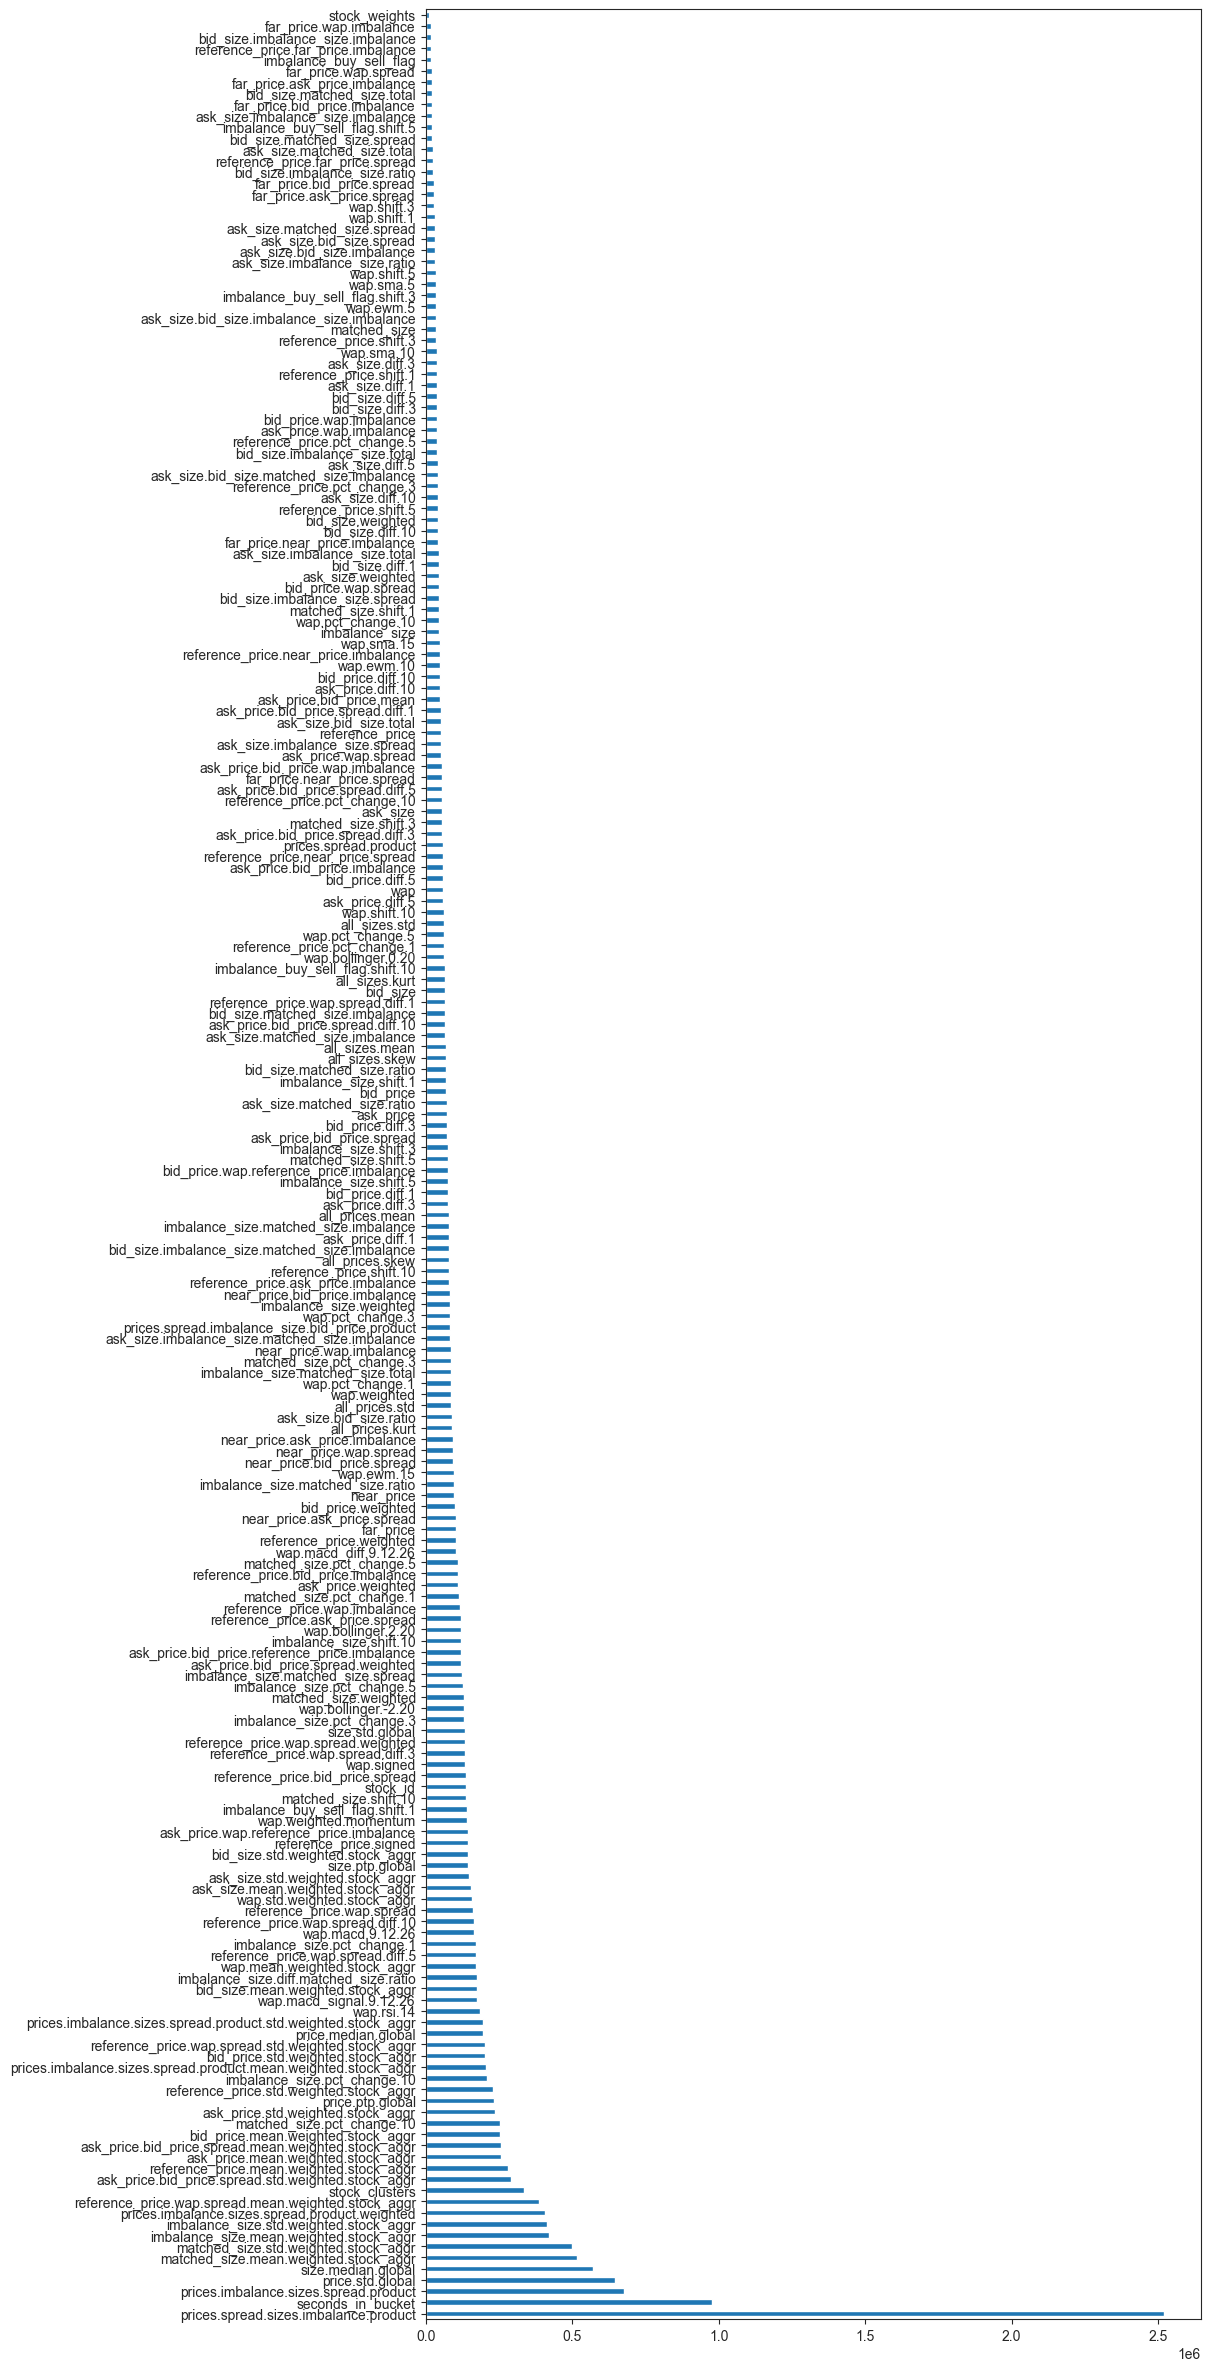

In [17]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 30))
agreggated_feature_importances.plot(kind='barh')

In [18]:
from utils.files import dump_json

if CFG.FEAT_COUNT > 0:
    selected_features = list(agreggated_feature_importances.index[:CFG.FEAT_COUNT]) # Select the desired results
else:
    selected_features = list(df.columns) # Select all

# Add essential features if not in the selected features
selected_features.extend(["target", "stock_id", "seconds_in_bucket"])
selected_features = list(dict.fromkeys(selected_features))

logger.info("Selected features are: ")
pprint(selected_features)

metadata = {
    "selected_features": selected_features,
    "stock_weights": stock_weights,
    "stock_clusters": stock_clusters,
    "global_features": {k: v.to_dict() for k, v in glob_feats.items()}
}
dump_json(CFG.JOB_PATH.joinpath(CFG.OUTPUT_METADATA_NAME), metadata, indent=4)

2023-12-06 00:43:20.269 | INFO     | __main__:<module>:12 - Selected features are: 


['stock_id',
 'seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'target',
 'ask_size.bid_size.spread',
 'ask_size.bid_size.total',
 'ask_size.bid_size.ratio',
 'ask_size.bid_size.imbalance',
 'ask_size.imbalance_size.spread',
 'ask_size.imbalance_size.total',
 'ask_size.imbalance_size.ratio',
 'ask_size.imbalance_size.imbalance',
 'ask_size.matched_size.spread',
 'ask_size.matched_size.total',
 'ask_size.matched_size.ratio',
 'ask_size.matched_size.imbalance',
 'bid_size.imbalance_size.spread',
 'bid_size.imbalance_size.total',
 'bid_size.imbalance_size.ratio',
 'bid_size.imbalance_size.imbalance',
 'bid_size.matched_size.spread',
 'bid_size.matched_size.total',
 'bid_size.matched_size.ratio',
 'bid_size.matched_size.imbalance',
 'imbalance_size.matched_size.spread',
 'imbalance_size.matched_size.total',
 'imbalance_size.matched_size.ratio',